In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('2012_public_use_data_aug2016.csv')
print(df.shape)

(6720, 1119)


In [3]:
df_codebook = pd.read_csv('grouped_2012microdata_codebook.csv')
print(df_codebook.columns)
df_codebook.head(5)

Index(['CATEOGORIES', 'File order', 'Variable\nname', 'Variable type',
       'Len-\ngth', 'Format', 'Label', 'Values/Format codes', 'Unnamed: 8'],
      dtype='object')


,CATEOGORIES,File order,Variable\nname,Variable type,Len-\ngth,Format,Label,Values/Format codes,Unnamed: 8
0,0,1.0,PUBID,Char,5.0,NaN,Building identifier,00001 - 06720,NaN
1,0,2.0,REGION,Char,1.0,$REGION.,Census region,'1' = 'Northeast'\n'2' = 'Midwest'\n'3' = 'Sou...,NaN
2,0,3.0,CENDIV,Char,1.0,$CENDIV.,Census division,'1' = 'New England'\n'2' = 'Middle Atlantic'\n...,NaN
3,0,4.0,PBA,Char,2.0,$PBA.,Principal building activity,'01' = 'Vacant'\n'02' = 'Office'\n'04' = 'Labo...,NaN
4,1,5.0,FREESTN,Char,1.0,$YES.,Freestanding building,1' = 'Yes'\nMissing='No',NaN


In [4]:
codebook_col_map = {
    'CATEOGORIES': 'category', 
    'File order': 'file_order', 
    'Variable\nname': 'col_name', 
    'Variable type': 'col_type',
    'Len-\ngth': 'length', 
    'Format': 'format', 
    'Label': 'col_description', 
    'Values/Format codes': 'codes', 
    'Unnamed: 8': 'empty'
}
df_codebook = df_codebook.rename(columns=codebook_col_map).drop(['empty'], axis=1)
df_codebook.head(5)

,category,file_order,col_name,col_type,length,format,col_description,codes
0,0,1.0,PUBID,Char,5.0,NaN,Building identifier,00001 - 06720
1,0,2.0,REGION,Char,1.0,$REGION.,Census region,'1' = 'Northeast'\n'2' = 'Midwest'\n'3' = 'Sou...
2,0,3.0,CENDIV,Char,1.0,$CENDIV.,Census division,'1' = 'New England'\n'2' = 'Middle Atlantic'\n...
3,0,4.0,PBA,Char,2.0,$PBA.,Principal building activity,'01' = 'Vacant'\n'02' = 'Office'\n'04' = 'Labo...
4,1,5.0,FREESTN,Char,1.0,$YES.,Freestanding building,1' = 'Yes'\nMissing='No'


In [5]:
cat0_vars = df_codebook[df_codebook.category == '0'].col_name.values
print(f'cat0_vars: {cat0_vars}')

categories = df_codebook.category.unique()
print(f'categories: {categories} | type: {type(categories)}')

cat0_vars: ['PUBID' 'REGION' 'CENDIV' 'PBA']
categories: ['0' '1' '2' '3' '4' '5' '6' '7' 'get rid of' '10'] | type: <class 'numpy.ndarray'>


In [6]:
category_map = {}
category_dfs = {}
for cat_name in categories:
    category_map[cat_name] = df_codebook[df_codebook['category'] == cat_name].col_name.values
    category_dfs[cat_name] = df_codebook[df_codebook['category'] == cat_name]
print(category_map['0'])
category_dfs['0']

['PUBID' 'REGION' 'CENDIV' 'PBA']


,category,file_order,col_name,col_type,length,format,col_description,codes
0,0,1.0,PUBID,Char,5.0,NaN,Building identifier,00001 - 06720
1,0,2.0,REGION,Char,1.0,$REGION.,Census region,'1' = 'Northeast'\n'2' = 'Midwest'\n'3' = 'Sou...
2,0,3.0,CENDIV,Char,1.0,$CENDIV.,Census division,'1' = 'New England'\n'2' = 'Middle Atlantic'\n...
3,0,4.0,PBA,Char,2.0,$PBA.,Principal building activity,'01' = 'Vacant'\n'02' = 'Office'\n'04' = 'Labo...


In [7]:
test_code_split = category_dfs['0'].drop(['category', 'file_order', 'col_type', 'length', 'format',], axis=1)
test_code_split['code_split'] = test_code_split.codes.str.split('\n')
test_code_split.set_index(keys=test_code_split.col_name, drop=True).T

col_name,PUBID,REGION,CENDIV,PBA
col_name,PUBID,REGION,CENDIV,PBA
col_description,Building identifier,Census region,Census division,Principal building activity
codes,00001 - 06720,'1' = 'Northeast'\n'2' = 'Midwest'\n'3' = 'Sou...,'1' = 'New England'\n'2' = 'Middle Atlantic'\n...,'01' = 'Vacant'\n'02' = 'Office'\n'04' = 'Labo...
code_split,[00001 - 06720],"['1' = 'Northeast', '2' = 'Midwest', '3' = 'So...","['1' = 'New England', '2' = 'Middle Atlantic',...","['01' = 'Vacant', '02' = 'Office', '04' = 'Lab..."


## EDA

Separated by Category (1-7, 10)

In [8]:
df = df.drop(columns=category_map['get rid of'])
print(df.shape)
df.sample(5)

(6720, 516)


,PUBID,REGION,CENDIV,PBA,FREESTN,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,FKCLBTU,FKWTBTU,FKCKBTU,FKOTBTU,DHHTBTU,DHCLBTU,DHWTBTU,DHCKBTU,DHOTBTU,PUBCLIM
782,783,3,7,5,NaN,4000,2,5,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
248,249,4,9,13,1.0,1500000,10,3,4,2,...,0.0,0.0,0.0,2999043.0,15909000.0,0.0,0.0,0.0,0.0,7
257,258,3,5,2,NaN,158000,7,2,6,1,...,0.0,0.0,0.0,24608.0,NaN,NaN,NaN,NaN,NaN,2
2641,2642,2,3,13,1.0,9300,3,4,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3535,3536,2,3,5,NaN,3000,2,4,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [9]:
new_1 = []
for cat_name in category_map['1']:
    if type(cat_name) == str:
        new_1.append(cat_name)
category_map['1'] = np.array(new_1)
category_map['1']

array(['FREESTN', 'SQFT', 'SQFTC', 'WLCNS', 'RFCNS', 'RFCOOL', 'RFTILT',
       'BLDSHP', 'GLSSPC', 'EQGLSS', 'SUNGLS', 'NFLOOR', 'BASEMNT',
       'FLCEILHT', 'ATTIC', 'ELEVTR', 'NELVTR', 'ESCLTR', 'NESLTR',
       'YRCON', 'YRCONC', 'MONCON', 'RENOV', 'RENADD', 'RENRDC', 'RENCOS',
       'RENINT', 'RENRFF', 'RENWLL', 'RENWIN', 'RENHVC', 'RENLGT',
       'RENPLB', 'RENELC', 'RENINS', 'RENSAF', 'RENSTR', 'RENOTH',
       'ONEACT', 'ACT1', 'ACT2', 'ACT3', 'ACT1PCT', 'ACT2PCT', 'ACT3PCT',
       'PBAPLUS', 'DRYCL', 'VACANT', 'CUBE', 'CUBEC', 'CUBELOC', 'RWSEAT',
       'PBSEAT', 'EDSEAT', 'FDSEAT', 'HCBED', 'NRSBED', 'LODGRM', 'COURT',
       'FACIL', 'FEDFAC', 'FACACT', 'MANIND', 'PLANT', 'FACDST', 'FACDHW',
       'FACDCW', 'FACELC', 'BLDPLT'], dtype='<U8')

In [10]:
dfs = {}
for cat_name, cat_list in category_map.items():
    if cat_name != 'get rid of':
        dfs[cat_name] = df[cat_list]
dfs['0'].sample(10)

,PUBID,REGION,CENDIV,PBA
4242,4243,3,6,12
5503,5504,1,1,18
1782,1783,3,6,2
70,71,4,9,14
878,879,4,8,5
2746,2747,3,5,13
2080,2081,2,4,13
4581,4582,3,5,25
3153,3154,1,2,8
3999,4000,2,3,14


In [11]:
dfs['0'].groupby('CENDIV').size()

CENDIV
1     319
2     787
3     900
4     559
5    1348
6     392
7     852
8     450
9    1113
dtype: int64

### EDA Category 1

Building Attributes - tried to select only continuous variables
1. Square Footage (SQFT) 1,001 - 1,500,000
2. Number of Floors (NFLOOR) 1-14, 994=15-25, 995= >25
3. Year of construction (YRCON) 995=<1946, 1946-2012
4. Any Renovations (RENOV) 1=yes, 2=no

Total Size n = 6720

Grouped by Rennovation status (`NFLOOR`, `SQFT`, `YRCON`) 
- RENOV = 1 
    - n = 3423
    - mean = 47.776220	173371.279287	1826.157172
    - median = 2	42000	1974
    - std = 206.210635	310598.178086	355.687342
- RENOV = 2 
    - n = 2936
    - mean = 11.026226	70129.489441	1883.572548
    - median = 1	10750	1985
    - std = 94.754694	174537.161246	301.333128
- RENOV Missing
    - n = 361
    
Visualizations
- I need to do some more precise manipulation to get a better idea of the spread of the data (i.e. having a hard time visualizing num floors and year constructed due to the flagged variables (994/995)

General Thoughts
- Roughly even distribution of unrennovated/rennovated buildings
- Coded data throws off averages, so better to use medians
- Older buildings without rennovations are larger (sqft/numfloor)
- Younger buildings with rennovations are smaller (sqft/numfloor)

In [12]:
cat1_descriptions = category_dfs['1'][['col_name', 'col_description']].to_dict(orient='records')
cat1_cols_interest_descriptions = ['Square footage', 'Number of floors',  'Year of construction', 'Any renovations',]
cat1_cols_interest = []
for dictionary in cat1_descriptions:
    if dictionary['col_description'] in cat1_cols_interest_descriptions:
        cat1_cols_interest.append(dictionary['col_name'])
        print(dictionary['col_description'])
cat1_cols_interest

#SQFT Codes (Continuous)
#1,001 - 1,500,000


#NFLOOR CODES (both Continuous/Categorical)
#"1 - 14
#994 = 15 to 25
#995 = More than 25"

#YRCON CODES (Mostly Continuous)
#"995 = Before 1946
#1946 - 2012"

#RENOV CODES
#"'1' = 'Yes'
#'2' = 'No'
#Missing = Not applicable"


Square footage
Number of floors
Year of construction
Any renovations


['SQFT', 'NFLOOR', 'YRCON', 'RENOV']

In [13]:
df1 = df[cat1_cols_interest]
df1_total = df1.shape[0]
renov_group = df1.groupby('RENOV').size()
print(df1_total)
print(renov_group)
print(df1_total - (renov_group[1] + renov_group[2]))

6720
RENOV
1.0    3423
2.0    2936
dtype: int64
361


In [14]:
df1.pivot_table(index='RENOV', values=['SQFT', 'NFLOOR', 'YRCON'], aggfunc=np.mean)

,NFLOOR,SQFT,YRCON
RENOV,,,
1.0,47.776220,173371.279287,1826.157172
2.0,11.026226,70129.489441,1883.572548


In [15]:
df1.pivot_table(index='RENOV', values=['SQFT', 'NFLOOR', 'YRCON'], aggfunc=np.std)

,NFLOOR,SQFT,YRCON
RENOV,,,
1.0,206.210635,310598.178086,355.687342
2.0,94.754694,174537.161246,301.333128


In [16]:
df1.pivot_table(index='RENOV', values=['SQFT', 'NFLOOR', 'YRCON'], aggfunc=np.min)

,NFLOOR,SQFT,YRCON
RENOV,,,
1.0,1,1050,995
2.0,1,1001,995


In [17]:
df1.pivot_table(index='RENOV', values=['SQFT', 'NFLOOR', 'YRCON'], aggfunc=np.max)

,NFLOOR,SQFT,YRCON
RENOV,,,
1.0,995,1500000,2007
2.0,995,1500000,2007


In [18]:
df1.pivot_table(index='RENOV', values=['SQFT', 'NFLOOR', 'YRCON'], aggfunc=np.median)

,NFLOOR,SQFT,YRCON
RENOV,,,
1.0,2,42000,1974
2.0,1,10750,1985


<AxesSubplot:xlabel='SQFT', ylabel='Count'>

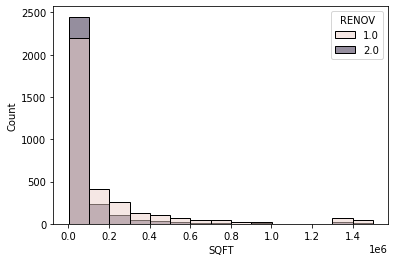

In [19]:
sns.histplot(df1, x='SQFT', binwidth=100000, hue='RENOV')

<AxesSubplot:xlabel='YRCON', ylabel='Count'>

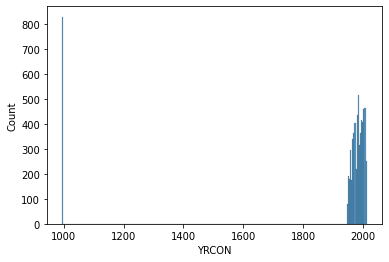

In [20]:
sns.histplot(df1, x='YRCON')

### EDA Category 2

Building Ownership - Not now

In [56]:
cat2_descriptions = category_dfs['2'][['col_name', 'col_description']].to_dict(orient='records')
cat2_descriptions

[{'col_name': 'GOVOWN', 'col_description': 'Government owned'},
 {'col_name': 'GOVTYP', 'col_description': 'Type of government'},
 {'col_name': 'OWNTYPE', 'col_description': 'Building owner'},
 {'col_name': 'NOCC', 'col_description': 'Number of businesses'},
 {'col_name': 'NOCCAT', 'col_description': 'Number of businesses category'},
 {'col_name': 'OWNOCC',
  'col_description': 'Owner occupied or leased to tenant(s)'},
 {'col_name': 'OWNOPR',
  'col_description': 'Owner responsible for operation and maintenance of energy systems'},
 {'col_name': 'OWNPPR',
  'col_description': 'Owner has purchasing power for energy-related equipment'},
 {'col_name': 'NWNPPR',
  'col_description': 'Nonowner with purchasing power for energy-related equipment'},
 {'col_name': 'NWNOPR',
  'col_description': 'Nonowner responsible for operation and maintenance of energy systems'},
 {'col_name': 'WHOPPR', 'col_description': 'Who has purchasing power'}]

### EDA Category 3

Operations

In [57]:
cat3_descriptions = category_dfs['3'][['col_name', 'col_description']].to_dict(orient='records')
cat3_descriptions

[{'col_name': 'MONUSE', 'col_description': 'Months in use'},
 {'col_name': 'OCCUPYP', 'col_description': 'Percent occupancy'},
 {'col_name': 'LODOCCP', 'col_description': 'Lodging room percent occupancy'},
 {'col_name': 'OPEN24', 'col_description': 'Open 24 hours a day'},
 {'col_name': 'OPNMF', 'col_description': 'Open during week'},
 {'col_name': 'OPNWE', 'col_description': 'Open on weekend'},
 {'col_name': 'WKHRS', 'col_description': 'Total hours open per week'},
 {'col_name': 'WKHRSC', 'col_description': 'Weekly hours category'},
 {'col_name': 'NWKER', 'col_description': 'Number of employees'},
 {'col_name': 'NWKERC', 'col_description': 'Number of employees category'}]

In [63]:
cat3_cols_interest_descriptions = ['Months in use', 'Percent occupancy',  'Lodging room percent occupancy', 'Total hours open per week', 'Number of employees']
cat3_cols_interest = []
for dictionary in cat3_descriptions:
    if dictionary['col_description'] in cat3_cols_interest_descriptions:
        cat3_cols_interest.append(dictionary['col_name'])
        print(dictionary['col_description'])
cat3_cols_interest

# MONUSE CODES
# 0 - 12

# OCCUPYP, LODOCCP
# 0-100

# WRKHRS
# 0-168

# NWKER
# 0-6500

Months in use
Percent occupancy
Lodging room percent occupancy
Total hours open per week
Number of employees


['MONUSE', 'OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER']

In [66]:
df3 = df[cat3_cols_interest]
df3.describe()

,MONUSE,OCCUPYP,LODOCCP,WKHRS,NWKER
count,6720.000000,1883.000000,231.000000,6720.000000,6720.000000
mean,11.323363,89.233670,65.948052,78.015030,178.778423
std,2.398353,16.700099,18.601470,51.367525,565.938093
min,0.000000,19.000000,10.000000,0.000000,0.000000
25%,12.000000,83.000000,58.000000,45.000000,4.000000
50%,12.000000,100.000000,70.000000,60.000000,15.000000
75%,12.000000,100.000000,80.000000,102.000000,80.000000
max,12.000000,100.000000,100.000000,168.000000,6500.000000


In [74]:
df3.groupby('MONUSE').size()

MONUSE
0      185
1       31
2       27
3       25
4       25
5       17
6       37
7       24
8       29
9      132
10     137
11      44
12    6007
dtype: int64

In [75]:
df3.pivot_table(index='MONUSE', values=['OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER'], aggfunc=np.mean)

,LODOCCP,NWKER,OCCUPYP,WKHRS
MONUSE,,,,
0,NaN,0.000000,NaN,0.000000
1,70.000000,88.645161,93.333333,74.354839
2,20.000000,30.407407,78.333333,70.037037
3,NaN,26.960000,87.500000,50.520000
4,NaN,6.000000,100.000000,46.880000
5,45.000000,23.705882,100.000000,76.235294
6,80.000000,17.486486,74.444444,64.162162
7,NaN,14.416667,86.666667,70.458333
8,66.500000,57.137931,100.000000,76.482759


In [76]:
df3.pivot_table(index='MONUSE', values=['OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER'], aggfunc=np.std)

,LODOCCP,NWKER,OCCUPYP,WKHRS
MONUSE,,,,
0,NaN,0.000000,NaN,0.000000
1,NaN,307.508217,11.547005,61.874361
2,NaN,65.737391,24.832774,52.108970
3,NaN,75.298008,25.000000,42.154596
4,NaN,6.324555,0.000000,36.688236
5,NaN,56.640053,0.000000,55.575995
6,14.142136,35.283472,33.302069,42.059160
7,NaN,32.430416,23.094011,43.545058
8,20.506097,161.514423,0.000000,45.823123


In [77]:
df3.pivot_table(index='MONUSE', values=['OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER'], aggfunc=np.min)

,LODOCCP,NWKER,OCCUPYP,WKHRS
MONUSE,,,,
0,NaN,0,NaN,0
1,70.0,0,80.0,0
2,20.0,0,50.0,0
3,NaN,0,50.0,2
4,NaN,0,100.0,0
5,45.0,0,100.0,0
6,70.0,0,25.0,0
7,NaN,0,60.0,0
8,52.0,0,100.0,10


In [78]:
df3.pivot_table(index='MONUSE', values=['OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER'], aggfunc=np.max)

,LODOCCP,NWKER,OCCUPYP,WKHRS
MONUSE,,,,
0,NaN,0,NaN,0
1,70.0,1500,100.0,168
2,20.0,250,100.0,168
3,NaN,300,100.0,168
4,NaN,20,100.0,168
5,45.0,230,100.0,168
6,90.0,150,100.0,168
7,NaN,125,100.0,168
8,81.0,859,100.0,168


In [79]:
df3.pivot_table(index='MONUSE', values=['OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER'], aggfunc=np.median)

,LODOCCP,NWKER,OCCUPYP,WKHRS
MONUSE,,,,
0,NaN,0,NaN,0.0
1,70.0,4,100.0,72.0
2,20.0,3,85.0,56.0
3,NaN,4,100.0,45.0
4,NaN,4,100.0,50.0
5,45.0,2,100.0,50.0
6,80.0,5,100.0,50.0
7,NaN,3,100.0,61.5
8,66.5,7,100.0,60.0


### EDA Category 4

Energy Source / Purpose

In [58]:
cat4_descriptions = category_dfs['4'][['col_name', 'col_description']].to_dict(orient='records')
cat4_descriptions

[{'col_name': 'HT1', 'col_description': 'Energy used for main heating'},
 {'col_name': 'HT2', 'col_description': 'Energy used for secondary heating'},
 {'col_name': 'COOL', 'col_description': 'Energy used for cooling'},
 {'col_name': 'WATR', 'col_description': 'Energy used for water heating'},
 {'col_name': 'COOK', 'col_description': 'Energy used for cooking'},
 {'col_name': 'MANU', 'col_description': 'Energy used for manufacturing'},
 {'col_name': 'CAPGEN',
  'col_description': 'Electricity generation capability'},
 {'col_name': 'GENR',
  'col_description': 'Energy used for electricity generation'},
 {'col_name': 'ANYEGY', 'col_description': 'Any energy used'},
 {'col_name': 'ELUSED', 'col_description': 'Electricity used'},
 {'col_name': 'NGUSED', 'col_description': 'Natural gas used'},
 {'col_name': 'FKUSED', 'col_description': 'Fuel oil/diesel/kerosene used'},
 {'col_name': 'FKTYPE',
  'col_description': 'Specify fuel oil, diesel, or kerosene'},
 {'col_name': 'PRUSED', 'col_descript

### EDA Category 5

Energy Management

In [59]:
cat5_descriptions = category_dfs['5'][['col_name', 'col_description']].to_dict(orient='records')
cat5_descriptions

[{'col_name': 'AMIMETER', 'col_description': 'AMI smart metering'},
 {'col_name': 'ENRGYPLN', 'col_description': 'Energy management plan'}]

### EDA Category 6

Service Industry Characteristics - Not right now

In [60]:
cat6_descriptions = category_dfs['6'][['col_name', 'col_description']].to_dict(orient='records')
cat6_descriptions

[{'col_name': 'SNACK', 'col_description': 'Snack bar or concession stand'},
 {'col_name': 'FASTFD', 'col_description': 'Fast food or small restaurant'},
 {'col_name': 'CAF', 'col_description': 'Cafeteria or large restaurant'},
 {'col_name': 'FDPREP', 'col_description': 'Commercial or large kitchen'},
 {'col_name': 'KITCHN', 'col_description': 'Small kitchen area'},
 {'col_name': 'BREAKRM',
  'col_description': 'Employee lounge, breakroom, or pantry'},
 {'col_name': 'OTFDRM', 'col_description': 'Other food prep or serving area'},
 {'col_name': 'HWTRM', 'col_description': 'Large amounts of hot water'},
 {'col_name': 'LAUNDR', 'col_description': 'Laundry onsite'},
 {'col_name': 'CONFSP', 'col_description': 'Conference or event space'},
 {'col_name': 'CONFSPP',
  'col_description': 'Percent conference or event space'},
 {'col_name': 'MEDEQP', 'col_description': 'Medical equipment'},
 {'col_name': 'XRAYN', 'col_description': 'Number of X-ray machines'},
 {'col_name': 'CTSCAN', 'col_descript

### Category 7

Lighting

In [61]:
cat7_descriptions = category_dfs['7'][['col_name', 'col_description']].to_dict(orient='records')
cat7_descriptions

[{'col_name': 'LTOHRP', 'col_description': 'Percent lit when open'},
 {'col_name': 'LOHRPC', 'col_description': 'Lit when open category'},
 {'col_name': 'LTNR24', 'col_description': 'Lights off during 24 hours'},
 {'col_name': 'LTNHRP', 'col_description': 'Percent lit off hours'},
 {'col_name': 'LNHRPC', 'col_description': 'Lit off hours category'},
 {'col_name': 'RDLTNF',
  'col_description': 'Lighting reduced during off hours'},
 {'col_name': 'FLUOR', 'col_description': 'Fluorescent bulbs'},
 {'col_name': 'CFLR', 'col_description': 'Compact fluorescent bulbs'},
 {'col_name': 'BULB', 'col_description': 'Incandescent bulbs'},
 {'col_name': 'HALO', 'col_description': 'Halogen bulbs'},
 {'col_name': 'HID',
  'col_description': 'High intensity discharge (HID) bulbs'},
 {'col_name': 'LED', 'col_description': 'Light-emitting diode (LED) bulbs'},
 {'col_name': 'OTLT', 'col_description': 'Other type of bulbs'},
 {'col_name': 'FLUORP', 'col_description': 'Percent lit by fluorescent'},
 {'col_n

### Category 10

Energy Expenses and Consumption

In [62]:
cat10_descriptions = category_dfs['10'][['col_name', 'col_description']].to_dict(orient='records')
cat10_descriptions

[{'col_name': 'HDD65', 'col_description': 'Heating degree days (base 65)'},
 {'col_name': 'CDD65', 'col_description': 'Cooling degree days (base 65)'},
 {'col_name': 'MFUSED', 'col_description': 'Any major fuel used'},
 {'col_name': 'MFBTU',
  'col_description': 'Annual major fuel consumption (thous Btu)'},
 {'col_name': 'MFEXP',
  'col_description': 'Annual major fuel expenditures ($)'},
 {'col_name': 'ELCNS',
  'col_description': 'Annual electricity consumption (kWh)'},
 {'col_name': 'ELBTU',
  'col_description': 'Annual electricity consumption (thous Btu)'},
 {'col_name': 'ELEXP',
  'col_description': 'Annual electricity expenditures ($)'},
 {'col_name': 'NGCNS',
  'col_description': 'Annual natural gas consumption (ccf)'},
 {'col_name': 'NGBTU',
  'col_description': 'Annual natural gas consumption (thous Btu)'},
 {'col_name': 'NGEXP',
  'col_description': 'Annual natural gas expenditures ($)'},
 {'col_name': 'FKCNS',
  'col_description': 'Annual fuel oil consumption (gallons)'},
 {